# 사이킷런으로 수행하는 타이타닉 생존자 예측

## 1. 타이타닉 탑승자 데이터
|column명|의미|
|:---:|:---:|
|Passengerid|탑승자 데이터 일련번호|
|survived|생존 여부 <br>(0 = 사망, 1 = 생존)|
|pclass|티켓 선실 등급 <br>(1 = 일등석, 2 = 이등석, 삼등석)|
|sex|탑승자 성별|
|name|탑승자 이름|
|Age|탑승자 나이|
|sibsp|같이 탑승한 형제자매, 배우자 인원수|
|parch|같이 탑승한 부모님, 어린이 인원수|
|ticket|티켓 번호|
|fare|요금|
|cabin|선실 번호|
|embarked|중간 정착 항구 <br>(C = Cherbourg, Q = Queenstown, S = Southampton)|

## 2. 데이터 전처리

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 2.1. 데이터 로딩

In [71]:
titanic_df = pd.read_csv('./train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 2.2. 데이터 크기, 자료형 및 결손값 확인
* `RangeIndex` : DataFrame 인덱스의 범위 = 전체 행의 수
* `Data columns` : 전체 열의 수
* `dtypes` : 각 열의 데이터 자료형의 수

In [72]:
print('데이터 정보 : \n')
print(titanic_df.info())

데이터 정보 : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


### 2.3. 결손값 처리
`Age`, `Cabin`, `Embarked`의 경우 Null값을 가지고 있으므로 이 값들을 다른 값(평균 or 고정값)으로 대체해야 한다. 

In [73]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)     # Age : 평균값
titanic_df['Cabin'].fillna('N', inplace=True)                        # Cabin : N
titanic_df['Embarked'].fillna('N', inplace=True)                     # Embarked : N

print('데이터 세트 Null값 개수 : ', titanic_df.isnull().sum().sum())

데이터 세트 Null값 개수 :  0


In [74]:
print('Sex값 분포 : \n', titanic_df['Sex'].value_counts())
print('\nCabin값 분포 : \n', titanic_df['Cabin'].value_counts())
print('\nEmbarked값 분포 : \n', titanic_df['Embarked'].value_counts())

Sex값 분포 : 
 male      577
female    314
Name: Sex, dtype: int64

Cabin값 분포 : 
 N                  687
B96 B98              4
C23 C25 C27          4
G6                   4
E101                 3
C22 C26              3
D                    3
F2                   3
F33                  3
C65                  2
B57 B59 B63 B66      2
E44                  2
B5                   2
C2                   2
B77                  2
C124                 2
C126                 2
E8                   2
B22                  2
B58 B60              2
C125                 2
C123                 2
D35                  2
B28                  2
B20                  2
E121                 2
E33                  2
D26                  2
D20                  2
D36                  2
                  ... 
D49                  1
B102                 1
E58                  1
B19                  1
B101                 1
B30                  1
D56                  1
E12                  1
B79                  1
F

`Cabin`의 경우 값들이 `C23`, `C25`, `C27`로 표현되어 있으므로 선실 등급만 나타나도록 슬라이싱 해준다.

In [75]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


### 2.4 생존률에 영향을 끼치는 데이터 파악
#### 2.4.1. 여성, 아이들, 노약자가 가장 먼저 구조되었다
* `여자` : 314명 중 233명이 생존 → 생존률 74.2%
* `남자` : 577명 중 109명이 생존 → 생존률 18.8%

In [76]:
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

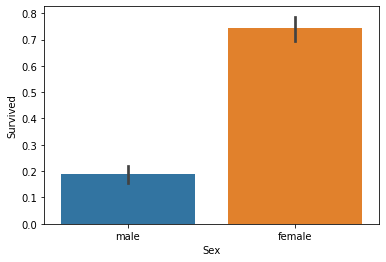

In [77]:
sns.barplot(x='Sex', y='Survived', data=titanic_df)

#### 2.4.2. 삼등실로 갈수록 생존확률이 떨어진다
* `여자` : 일, 이등실의 생존확률은 큰 차이가 나지 않으나 삼등실의 경우 생존 확률이 상대적으로 많이 떨어짐
* `남자` : 일등실의 경우 생존확률이 높고 이, 삼들실의 경우 생존 확률이 많이 떨어짐

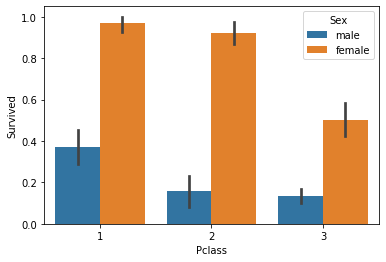

In [78]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

#### 2.4.3. 결론
`Sex`, `Age`, `PClass` 이 세 가지 요소는 연관이 있다. 여성이고, 나이가 아주 많거나 적고, 일등석을 탈수록 생존확률이 높았다.

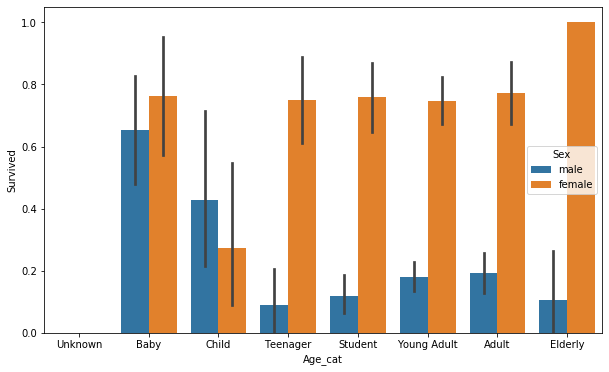

In [79]:
# 나이를 입력으로 받으면 구분 값을 반환하는 함수
def get_category(age):
    cat = ''
    if age <= -1   : cat = 'Unknown'
    elif age <= 5  : cat = 'Baby'
    elif age <= 12 : cat = 'Child'
    elif age <= 18 : cat = 'Teenager'
    elif age <= 25 : cat = 'Student'
    elif age <= 35 : cat = 'Young Adult'
    elif age <= 60 : cat = 'Adult'
    else : cat = 'Elderly'
        
    return cat

# 막대그래프 : figure 크기 설정
plt.figure(figsize=(10, 6))

# x축의 값을 순차적으로 표시
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# get_category()로 나이(숫자)를 해당 카데고리로 변환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

### 2.5. 데이터 전처리

In [80]:
from sklearn import preprocessing

def encode_features(df):
    features = ['Cabin', 'Sex', 'Embarked']
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    
    return df

titanic_df = encode_features(titanic_df)
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


In [86]:
# Null값 처리
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    return df

In [87]:
# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    
    return df

## 3. 학습/예측

### 3.1. 피처/레이블 데이터 분리

In [88]:
titanic_df = pd.read_csv('./train.csv')
y_titanic_df = titanic_df['Survived']                 # 레이블 데이터 세트
X_titanic_df = titanic_df.drop('Survived', axis=1)    # 피처 데이터 세트

X_titanic_df = transform_features(X_titanic_df)       # 데이터 전처리

### 3.2. 학습/테스트 데이터 분리

In [89]:
from sklearn.model_selection import train_test_split

# 테스트 데이터 세트를 20%로 해서 분리
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

### 3.3. 학습 및 예측

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도:0.8324


C:\Users\round\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\round\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression 정확도: 0.8659


## 4. 교차 검증
### 4.1. KFold 교차 검증

In [96]:
from sklearn.model_selection import KFold

# K Fold 교차 검증
def exec_kfold(clf, folds=5):
    kfold = KFold(n_splits=folds)    # 폴드 세트가 5개인 K Fold 객체 생성
    scores = []                      # 예측 결과 저장
    
    # K Fold 교차 검증 수행
    for iter_cnt, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df를 학습/검증 데이터로 분리 (index)
        # 데이터 세트(ndarray)를 불러와서 해당 index에 해당하는 값들만 추출
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습/예측/정확도 계산
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        scores.append(accuracy)
        print('교차 검증 [{0}] 정확도 : {1:.4f}'.format(iter_cnt, accuracy))
        
    # 5개 fold에서의 평균 정확도 계산
    mean_score = np.mean(scores)
    print('평균 정확도 : {0:.4f}'.format(mean_score)) 

In [97]:
exec_kfold(dt_clf, folds=5)

교차 검증 [0] 정확도 : 0.7542
교차 검증 [1] 정확도 : 0.7809
교차 검증 [2] 정확도 : 0.7865
교차 검증 [3] 정확도 : 0.7697
교차 검증 [4] 정확도 : 0.8202
평균 정확도 : 0.7823


### 4.2. `cross_val_score`
`cross_val_score()`는 StratifiedKFold를 이용해 폴드 세트를 분할한다.

In [100]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)

for iter_cnt, accuracy in enumerate(scores):
    print('교차 검증 [{0}] 정확도 : {1:.4f}'.format(iter_cnt, accuracy))
    
print('평균 정확도 : {0:.4f}'.format(np.mean(scores)))

교차 검증 [0] 정확도 : 0.7430
교차 검증 [1] 정확도 : 0.7765
교차 검증 [2] 정확도 : 0.7809
교차 검증 [3] 정확도 : 0.7753
교차 검증 [4] 정확도 : 0.8418
평균 정확도 : 0.7835


### 4.3. GridSearchCV
GridSearchCV를 이용해 `DecisionTreeClassifier`의 최적 하이퍼 파리미터를 찾고 예측 성능을 측정한다.

In [102]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2, 3, 5, 10], 'min_samples_split':[2, 3, 5], 'min_samples_leaf':[1, 5, 8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)     # 모델
grid_dclf.fit(X_train, y_train)      # 학습

print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파리미터로 학습된 Estimator로 예측/평가 수행 
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearchCV 최고 정확도 : 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715


C:\Users\round\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 5. 정리
#### ① 데이터 전처리 - 최적의 데이터를 제공
- 클렌징 작업 : 오류 데이터의 보정, 결손값(NULL) 처리
- 인코딩 작업 : 레이블 인코딩, 원-핫 인코딩
- 데이터 스케일링, 정규화 작업       

#### ② 학습/테스트 데이터로 분리 뒤 머신러닝 알고리즘 학습/예측

#### ③ 교차 검증을 통한 평가    
- 학습 데이터로 학습한 뒤 별도로 분리된 테스트 데이터로 평가
- 테스트 데이터가 부족하거나 똑같은 테스트 데이터 세트로 학습/평가를 할 경우 잘못된 모델이 만들어질 수 있음
- `KFold`, `Stratified KFold`, `cross_val_score()`를 이용하여 교차검증 가능
- `GridSearchCV`를 이용하면 교차 검증을 통해 최적의 하이퍼 파라미터를 추출할 수 있음